In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# LightGBM + XGBoost 앙상블 + 클리핑 + EDA 강화

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 1. 데이터 로드

In [3]:
df = pd.read_csv("/content/drive/MyDrive/SC/Hackathon/기업 성공 확률 예측/investments_VC.csv", encoding='ISO-8859-1')

# 2. 초기 데이터 확인

In [4]:
print("초기 데이터 크기:", df.shape)
print(df.dtypes)
print(df['status'].value_counts())  # 성공 여부 비율 확인

초기 데이터 크기: (54294, 39)
permalink                object
name                     object
homepage_url             object
category_list            object
 market                  object
 funding_total_usd       object
status                   object
country_code             object
state_code               object
region                   object
city                     object
funding_rounds          float64
founded_at               object
founded_month            object
founded_quarter          object
founded_year            float64
first_funding_at         object
last_funding_at          object
seed                    float64
venture                 float64
equity_crowdfunding     float64
undisclosed             float64
convertible_note        float64
debt_financing          float64
angel                   float64
grant                   float64
private_equity          float64
post_ipo_equity         float64
post_ipo_debt           float64
secondary_market        float64
product_crowdfund

# 3. 타겟값 없는 행 제거

In [5]:
df = df[df['status'].notnull()]

# 4. 타겟 변수 생성: operating이면 성공(1), 아니면 실패(0)

In [6]:
df['success'] = df['status'].apply(lambda x: 1 if x == 'operating' else 0)

# 5. 분석에 필요 없는 열 제거 (결측 많거나 설명력이 낮은 컬럼들)

In [7]:
drop_cols = ['name', 'homepage_url', 'status', 'state_code', 'region', 'city',
             'first_funding_at', 'last_funding_at', 'founded_month',
             'founded_quarter', 'founded_day', 'permalink']
df = df.drop(columns=drop_cols, errors='ignore')

# 6. 설립일을 기반으로 연도 및 기업 나이 생성

## 날짜 형식으로 변환 후 연도 추출

In [8]:
df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')
df['founded_year'] = df['founded_at'].dt.year

## 비현실적인 연도 제거 및 중앙값으로 대체

In [9]:
df['founded_year'] = df['founded_year'].where(df['founded_year'] > 1900, np.nan)
df['founded_year'].fillna(df['founded_year'].median(), inplace=True)
df['company_age'] = 2024 - df['founded_year']

<ipython-input-9-2c3ce8db4580>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['founded_year'].fillna(df['founded_year'].median(), inplace=True)


# 7. 총 투자금 처리: 숫자로 변환 후 결측치는 0으로 대체

In [10]:
print(df.columns.tolist())

['category_list', ' market ', ' funding_total_usd ', 'country_code', 'funding_rounds', 'founded_at', 'founded_year', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H', 'success', 'company_age']


In [11]:
df.columns = [col.strip() for col in df.columns]  # 공백 제거

In [12]:
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)

# 8. 범주형 변수 처리: 결측치는 'Unknown'으로 채운 뒤 라벨 인코딩

In [13]:
# 산업군(category_list), 국가(country_code)만 사용
df['category_list'] = df['category_list'].fillna('Unknown')
df['country_code'] = df['country_code'].fillna('Unknown')

le_cat = LabelEncoder()
df['category_encoded'] = le_cat.fit_transform(df['category_list'])
le_country = LabelEncoder()
df['country_encoded'] = le_country.fit_transform(df['country_code'])

# 9. 최종 피처 선택

In [14]:
X = df[['funding_total_usd', 'company_age', 'category_encoded', 'country_encoded']]
y = df['success']

# 10. 피처 확장: 주요 투자유형 및 펀딩 라운드 포함

In [36]:
df.columns = [col.strip() for col in df.columns]  # 공백 제거
feature_cols = ['funding_total_usd', 'company_age', 'category_encoded', 'country_encoded',
                'funding_rounds', 'seed', 'venture', 'angel', 'private_equity',
                'round_A', 'round_B', 'round_C']
X = df[feature_cols]
y = df['success']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 11. 모델 정의: scale_pos_weight

In [37]:
scale = y_train.value_counts()[0] / y_train.value_counts()[1]
scale = y_train.value_counts()[0] / y_train.value_counts()[1]
lgbm = LGBMClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    scale_pos_weight=scale,
    random_state=42
)

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# 12. 모델 학습

In [38]:
lgbm.fit(X_train, y_train)
xgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 33463, number of negative: 5036
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2473
[LightGBM] [Info] Number of data points in the train set: 38499, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.869191 -> initscore=1.893828
[LightGBM] [Info] Start training from score 1.893828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:58:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

# 13. 예측 확률 추출 후 평균 앙상블 (소프트 앙상블)

In [39]:
pred_lgbm = lgbm.predict_proba(X_test)[:, 1]
pred_xgb = xgb.predict_proba(X_test)[:, 1]
pred_avg = (pred_lgbm + pred_xgb) / 2

# 14. 클리핑: 예측값이 0~1 범위를 넘지 않도록 제한

In [40]:
pred_clipped = np.clip(pred_avg, 0, 1)

# 15. 예측 결과 이진화 후 평가

In [41]:
threshold = 0.2
pred_binary = (pred_clipped >= threshold).astype(int)
print(classification_report(y_test, pred_binary))
print("ROC AUC Score:", roc_auc_score(y_test, pred_clipped))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_binary))

              precision    recall  f1-score   support

           0       0.67      0.00      0.00      1259
           1       0.87      1.00      0.93      8366

    accuracy                           0.87      9625
   macro avg       0.77      0.50      0.47      9625
weighted avg       0.84      0.87      0.81      9625

ROC AUC Score: 0.7494593552290114
Confusion Matrix:
 [[   2 1257]
 [   1 8365]]


# 16. 피처 중요도 시각화 함수 정의

In [42]:
def plot_importance(model, model_name):
    importance = model.feature_importances_
    features = X.columns
    indices = np.argsort(importance)
    plt.figure(figsize=(8, 4))
    plt.title(f"{model_name} Feature Importance")
    sns.barplot(x=importance[indices], y=features[indices])
    plt.tight_layout()
    plt.show()

# 17. 중요도 시각화 실행

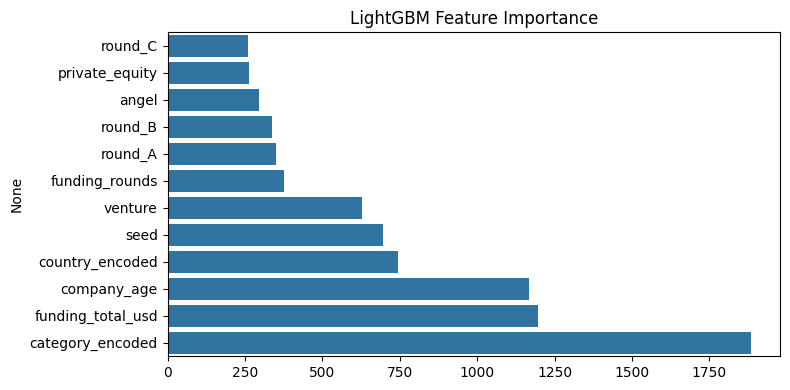

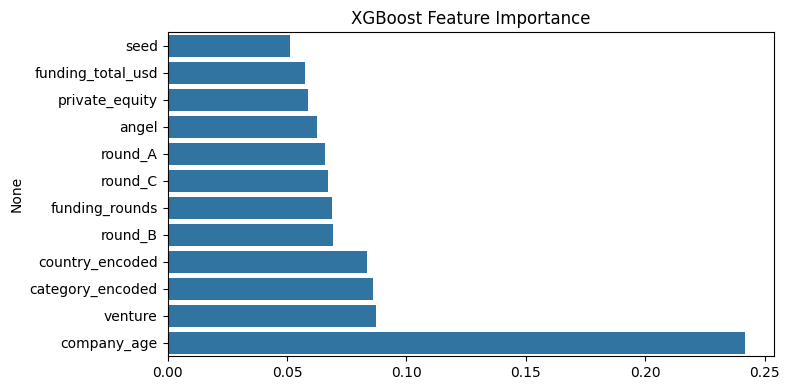

In [43]:
plot_importance(lgbm, "LightGBM")
plot_importance(xgb, "XGBoost")